<img src="https://drive.google.com/uc?export=view&id=1wYSMgJtARFdvTt5g7E20mE4NmwUFUuog" width="200">

[![Build Fast with AI](https://img.shields.io/badge/BuildFastWithAI-GenAI%20Bootcamp-blue?style=for-the-badge&logo=artificial-intelligence)](https://www.buildfastwithai.com/genai-course)
[![EduChain GitHub](https://img.shields.io/github/stars/satvik314/educhain?style=for-the-badge&logo=github&color=gold)](https://github.com/satvik314/educhain)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1yYm2GSy7KVtYOFKpw486wVCRoxYYuSXk?usp=sharing)
## Master Generative AI in 6 Weeks
**What You'll Learn:**
- Build with Latest LLMs
- Create Custom AI Apps
- Learn from Industry Experts
- Join Innovation Community
Transform your AI ideas into reality through hands-on projects and expert mentorship.
[Start Your Journey](https://www.buildfastwithai.com/genai-course)
*Empowering the Next Generation of AI Innovators

# 🛠️✨ **E2B (Execution to Bot)**  
E2B is a powerful Python library designed to seamlessly integrate **execution environments** with **language models**, enabling tasks like **code execution**, **data analysis**, and **automated problem-solving**. With E2B, you can:

- 💻 **Run Python code** securely in a controlled environment (sandbox).
- 🤖 **Generate Python code** from natural language instructions.
- ⚙️ **Automate workflows** by executing complex code and processing data with the help of language models.
- 📊 **Visualize data** and perform **advanced analytics** with ease.

E2B allows developers and data scientists to combine the power of **language models** with a **robust execution environment**, improving efficiency and simplifying tasks like code generation, execution, and data analysis. 🚀


## **LangChain + Function Calling + E2B Code Interpreter Integration**







### **Install Required Libraries**


In [ ]:
%pip install e2b_code_interpreter==1.0.0 langchain langchainhub langchain-openai

###**Configure OpenAI API**

In [2]:
import os
from google.colab import userdata
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')
OPENAIKEY=os.getenv('OPENAI_API_KEY')
os.environ['E2B_API_KEY'] = userdata.get('E2B_API_KEY')
E2BKEY=os.getenv('E2B_API_KEY')

### **Define Code Interpreter Tool Class for Langchain Integration**

In [3]:
import os
import json

from typing import Any, List
from langchain_core.tools import Tool
from pydantic.v1 import BaseModel, Field
from e2b_code_interpreter import Sandbox
from langchain_core.messages import BaseMessage, ToolMessage
from langchain.agents.output_parsers.tools import (
    ToolAgentAction,
)


class LangchainCodeInterpreterToolInput(BaseModel):
    code: str = Field(description="Python code to execute.")


class CodeInterpreterFunctionTool:
    """
    This class calls arbitrary code against a Python Jupyter notebook.
    It requires an E2B_API_KEY to create a sandbox.
    """

    tool_name: str = "code_interpreter"

    def __init__(self):

        if "E2B_API_KEY" not in os.environ:
            raise Exception(
                "Code Interpreter tool called while E2B_API_KEY environment variable is not set."
            )
        self.code_interpreter = Sandbox()

    def call(self, parameters: dict, **kwargs: Any):
        code = parameters.get("code", "")
        print(f"***Code Interpreting...\n{code}\n====")
        execution = self.code_interpreter.run_code(code)
        return {
            "results": execution.results,
            "stdout": execution.logs.stdout,
            "stderr": execution.logs.stderr,
            "error": execution.error,
        }

    def close(self):
        self.code_interpreter.kill()

    def langchain_call(self, code: str):
        return self.call({"code": code})

    def to_langchain_tool(self) -> Tool:
        tool = Tool(
            name=self.tool_name,
            description="Execute python code in a Jupyter notebook cell and returns any rich data (eg charts), stdout, stderr, and error.",
            func=self.langchain_call,
        )
        tool.args_schema = LangchainCodeInterpreterToolInput
        return tool

    @staticmethod
    def format_to_tool_message(
        agent_action: ToolAgentAction,
        observation: dict,
    ) -> List[BaseMessage]:
        """
        Format the output of the CodeInterpreter tool to be returned as a ToolMessage.
        """
        new_messages = list(agent_action.message_log)

        content = json.dumps(
            {k: v for k, v in observation.items() if k not in ("results")}, indent=2
        )
        new_messages.append(
            ToolMessage(content=content, tool_call_id=agent_action.tool_call_id)
        )

        return new_messages

###Import Required Libraries

In [4]:
from typing import List, Sequence, Tuple
from langchain_core.prompts import ChatPromptTemplate
from langchain.agents import AgentExecutor
from langchain_openai import ChatOpenAI
from langchain_core.messages import BaseMessage
from langchain_core.runnables import RunnablePassthrough
from langchain.agents.output_parsers.tools import (
    ToolAgentAction,
    ToolsAgentOutputParser,
)

#### **Format Intermediate Steps to Tool Messages for LangChain Integration**

In [5]:
def format_to_tool_messages(
    intermediate_steps: Sequence[Tuple[ToolAgentAction, dict]],
) -> List[BaseMessage]:
    messages = []
    for agent_action, observation in intermediate_steps:
        if agent_action.tool == CodeInterpreterFunctionTool.tool_name:
            new_messages = CodeInterpreterFunctionTool.format_to_tool_message(
                agent_action,
                observation,
            )
            messages.extend([new for new in new_messages if new not in messages])
        else:
            # Handle other tools
            print("Not handling tool: ", agent_action.tool)

    return messages

### **Pick Your Favorite LLM 🤖**



In [16]:
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

### **Initialize the Code Interpreter Tool 🛠️**

In [17]:
code_interpreter = CodeInterpreterFunctionTool()
code_interpreter_tool = code_interpreter.to_langchain_tool()
tools = [code_interpreter_tool]

### **Define the Prompt ✍️**


In [18]:
prompt = ChatPromptTemplate.from_messages(
    [("human", "{input}"), ("placeholder", "{agent_scratchpad}")]
)


###**Define the agent**

In [19]:
agent = (
    RunnablePassthrough.assign(
        agent_scratchpad=lambda x: format_to_tool_messages(x["intermediate_steps"])
    )
    | prompt
    | llm.bind_tools(tools)
    | ToolsAgentOutputParser()
)

agent_executor = AgentExecutor(
    agent=agent,
    tools=tools,
    verbose=True,
    return_intermediate_steps=True,
)

### **Invoke Agent Executor and Retrieve Results 📊**





> Entering new AgentExecutor chain...

Invoking: `code_interpreter` with `{'code': "import numpy as np\nimport matplotlib.pyplot as plt\n\n# Generate x values\nx = np.linspace(0, 2 * np.pi, 100)\n# Calculate the sine of x\ny = np.sin(x)\n\n# Create the plot\nplt.figure(figsize=(10, 5))\nplt.plot(x, y, label='sin(x)', color='blue')\nplt.title('Sine Function')\nplt.xlabel('x (radians)')\nplt.ylabel('sin(x)')\nplt.axhline(0, color='black',linewidth=0.5, ls='--')\nplt.axvline(0, color='black',linewidth=0.5, ls='--')\nplt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)\nplt.legend()\nplt.show()"}`


***Code Interpreting...
import numpy as np
import matplotlib.pyplot as plt

# Generate x values
x = np.linspace(0, 2 * np.pi, 100)
# Calculate the sine of x
y = np.sin(x)

# Create the plot
plt.figure(figsize=(10, 5))
plt.plot(x, y, label='sin(x)', color='blue')
plt.title('Sine Function')
plt.xlabel('x (radians)')
plt.ylabel('sin(x)')
plt.axhline(0, color='black',linewidth=0.5, ls='--'

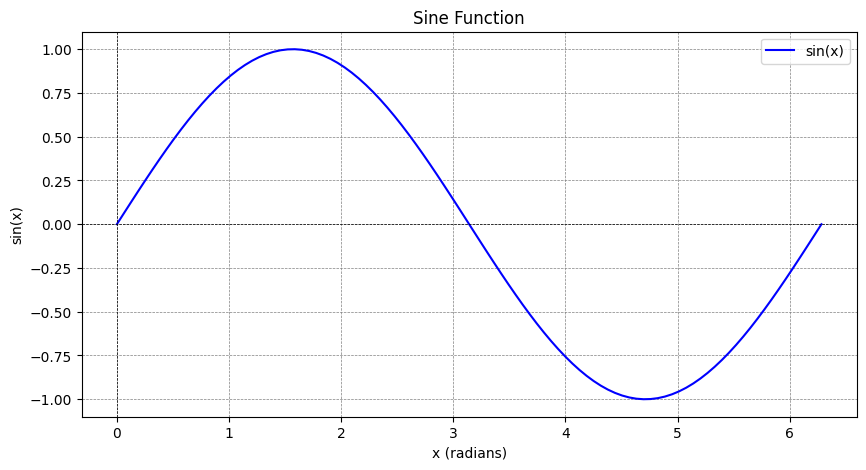

In [20]:
result = agent_executor.invoke({"input": "plot and show sinus"})


result["intermediate_steps"][0][1]["results"][0]

## **Code Interpreting with GPT-4o 🤖💻**







In [12]:
import os

SYSTEM_PROMPT = """
## your job & context
you are a python data scientist. you are given tasks to complete and you run python code to solve them.
You DO NOT MAKE SYNTAX MISTAKES OR FORGET ANY IMPORTS
- the python code runs in jupyter notebook.
- every time you call `execute_python` tool, the python code is executed in a separate cell. it's okay to multiple calls to `execute_python`.
- display visualizations using matplotlib or any other visualization library directly in the notebook. don't worry about saving the visualizations to a file.
- you have access to the internet and can make api requests.
- you also have access to the filesystem and can read/write files.
- you can install any pip package (if it exists) if you need to but the usual packages for data analysis are already preinstalled.
- you can run any python code you want, everything is running in a secure sandbox environment.
"""

tools = [
    {
        "type": "function",
        "function": {
          "name": "execute_python",
          "description": "Execute python code in a Jupyter notebook cell and returns any result, stdout, stderr, display_data, and error.",
          "parameters": {
              "type": "object",
              "properties": {
                  "code": {
                      "type": "string",
                      "description": "The python code to execute in a single cell."
                  }
              },
              "required": ["code"]
          }
        },
    }
]

### **Code Interpretation Function with E2B Code Interpreter 🔍**







In [13]:
def code_interpret(e2b_code_interpreter, code):
  print("Running code interpreter...")
  exec = e2b_code_interpreter.run_code(code,
  on_stderr=lambda stderr: print("[Code Interpreter]", stderr),
  on_stdout=lambda stdout: print("[Code Interpreter]", stdout))

  if exec.error:
    print("[Code Interpreter ERROR]", exec.error)
  else:
    return exec.results

In [14]:
from openai import OpenAI
import json

client = OpenAI(api_key=OPENAIKEY)

def chat(e2b_code_interpreter, user_message, base64_image = None, ):
  print(f"\n{'='*50}\nUser Message: {user_message}\n{'='*50}")

  messages = [
      {
          "role": "system",
          "content": SYSTEM_PROMPT,
      },
  ]

  if base64_image is not None:
    messages.append(
        {
          "role": "user",
          "content": [
            {
              "type": "text",
              "text": user_message,
            },
            {
              "type": "image_url",
              "image_url": {
                "url": f"data:image/jpeg;base64,{base64_image}"
              }
            }
          ]
        }
    )
  else:
    messages.append(
        {"role": "user", "content": user_message},
    )

  response = client.chat.completions.create(
    model="gpt-4o",
    messages=messages,
    tools=tools,
    tool_choice="auto"
  )
  for choice in response.choices:
    if choice.message.tool_calls and len(choice.message.tool_calls) > 0:
      for tool_call in choice.message.tool_calls:
        if tool_call.function.name == "execute_python":
          if isinstance(tool_call.function.arguments, dict) and "code" in tool_call.function.arguments:
            code = tool_call.function.arguments["code"]
          else:
            code = json.loads(tool_call.function.arguments)["code"]

            print("CODE TO RUN")
            print(code)
            code_interpreter_results = code_interpret(e2b_code_interpreter, code)
            return code_interpreter_results
    else:
      print("Answer:", choice.message.content)

### **Generate and Visualize Chart Using GPT-4o and E2B Code Interpreter 📊🤖**


User Message: Plot a chart visualizing the height distribution of men based on the data you know
CODE TO RUN
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Generating synthetic data for men's height
np.random.seed(0)  # Seed for reproducibility
mean_height = 175  # Mean height in cm
std_dev = 10  # Standard deviation in cm
num_samples = 1000  # Number of samples

# Generate normal distribution
heights = np.random.normal(mean_height, std_dev, num_samples)

# Plot the distribution using seaborn
plt.figure(figsize=(10, 6))
sns.histplot(heights, bins=30, kde=True, color='blue', edgecolor='black')
plt.title('Height Distribution of Men')
plt.xlabel('Height (cm)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()
Running code interpreter...
[Result(<Figure size 1000x600 with 1 Axes>)]


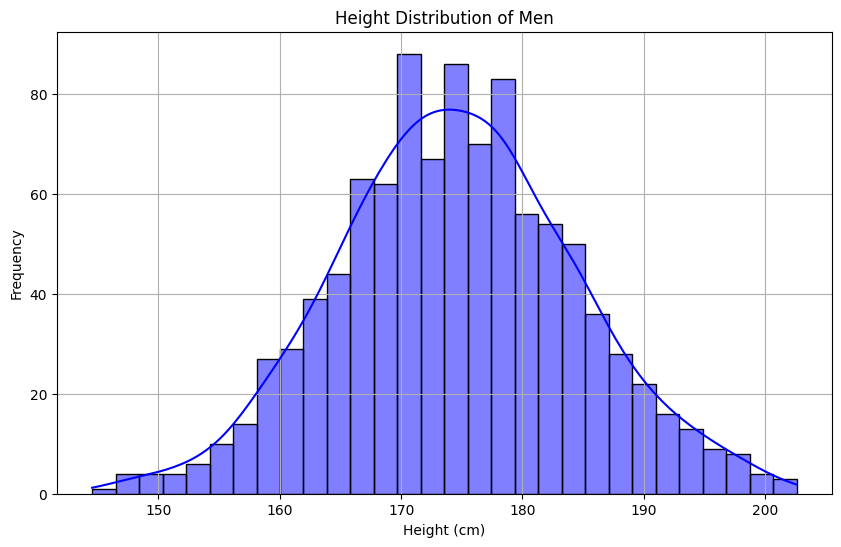

In [15]:
from e2b_code_interpreter import Sandbox
code_interpreter = Sandbox(api_key=E2BKEY)

# 1. Ask GPT-4o to generate chart
code_interpreter_results = chat(
  code_interpreter,
  "Plot a chart visualizing the height distribution of men based on the data you know",
)
print(code_interpreter_results)
plot1 = code_interpreter_results[0]

plot1